In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
from IPython.display import display, HTML
import glob
from zedstat import zedstat

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
import optuna

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# Methods

In [2]:
from quasinet.qsampling import qsample
from scipy.stats import entropy
import random
from quasinet.utils import sample_from_dict
from quasinet.qnet import save_qnet
from pathlib import Path


def _get_qnet(df):
    from quasinet import qnet

    qn = qnet.Qnet(
        feature_names=df.columns.values,
        min_samples_split=2,
        alpha=0.05,
        max_depth=-1,
        max_feats=-1,
        early_stopping=False,
        verbose=0,
        random_state=None,
        n_jobs=-1,
    )

    qn.fit(df.to_numpy(dtype="<U21"))

    return qn


def _get_tnets(
    df,
    df_pos=None,
    df_neg=None,
    diss_file=None,
    suspects=None,
    alpha=0.01,
):
    if df_pos is not None and df_neg is not None:
        non_null_cols = (
            (df.isna().sum() < len(df))
            & (df_pos.isna().sum() < len(df_pos))
            & (df_neg.isna().sum() < len(df_neg))
        )

        df_fmtd = df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        df_pos_fmtd = (
            df_pos.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )
        df_neg_fmtd = (
            df_neg.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )
        df_fmtd.to_csv("df_tmp.csv", index=False)
        df_pos_fmtd.to_csv("df_pos_tmp.csv", index=False)
        df_neg_fmtd.to_csv("df_neg_tmp.csv", index=False)

        if suspects is not None:
            Tr = truthnet()

            Tr_pos = truthnet()
            features, samples = Tr.load_data(datapath="df_tmp.csv")
            features_pos, samples_pos = Tr_pos.load_data(datapath="df_pos_tmp.csv")
            Tr.fit(modelpath="tmp_Qnet.joblib")
            Tr_pos.fit(modelpath="tmp_Qnet_pos.joblib")
            if diss_file is not None:
                Tr.dissonance = pd.read_csv(diss_file)
            else:
                Tr.getDissonance(outfile="data/tmp_dissonance_matrix.csv")
                Tr_pos.getDissonance(outfile="data/tmp_dissonance_matrix_pos.csv")
            for alpha in [0.01, 0.05, 0.1]:
                Tr.getSuspects(alpha=alpha).to_csv(f"{suspects}_full_model_{alpha}.csv")
                Tr_pos.getSuspects(alpha=alpha).to_csv(
                    f"{suspects}_pos_model_{alpha}.csv"
                )

        Tr = _get_qnet(df_fmtd)
        Tr_pos = _get_qnet(df_pos_fmtd)
        Tr_neg = _get_qnet(df_neg_fmtd)
    else:  # core mode
        Tr = truthnet()
        length = sum(df.isna().sum() < len(df))
        df.fillna(-9).astype(int).replace(-9, "").to_csv("tmpfile.csv", index=False)
        features, samples = Tr.load_data(datapath="tmpfile.csv")
        Tr.fit(modelpath="tmp_Qnet.joblib")
        if diss_file is not None:
            Tr.dissonance = pd.read_csv(diss_file)
        else:
            Tr.getDissonance(outfile="data/tmp_dissonance_matrix.csv")
        if suspects is not None:
            for alpha in [0.01, 0.05, 0.1]:
                Tr.getSuspects(alpha=alpha).to_csv(f"{suspects}_{alpha}.csv")
        coresamples = Tr.getCoresamples(alpha=alpha, steps=length)
        df_pos = df.loc[coresamples.index.values]
        if len(coresamples) == len(df):
            df_neg = None
            non_null_cols = (df.isna().sum() < len(df)) & (
                df_pos.isna().sum() < len(df_pos)
            )
            Tr_neg = None
            Tr = _get_qnet(
                df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
            )
            Tr_pos = Tr

        else:
            df_neg = df.loc[~df.index.isin(coresamples.index.values)]

            non_null_cols = (
                (df.isna().sum() < len(df))
                & (df_pos.isna().sum() < len(df_pos))
                & (df_neg.isna().sum() < len(df_neg))
            )

            Tr = _get_qnet(
                df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
            )
            Tr_pos = _get_qnet(
                df_pos.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
            )
            Tr_neg = _get_qnet(
                df_neg.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
            )

    return {
        "all": Tr,
        "pos": Tr_pos,
        "neg": Tr_neg,
        "data": df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, ""),
        # "core": coresamples,
    }


def _diss_linear(s, qnet, missing_value=0):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            elif s[i] == "missing":
                diss.append(missing_value)
            else:
                diss.append(1)

    return np.array(diss)


def _diss_log(s, qnet, missing_value=0):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(-np.log(Ds[i][s[i]]))
            elif s[i] == "missing":
                diss.append(missing_value)
            else:
                diss.append(np.inf)
        # else:
        # diss.append(missing_value)

    return np.array(diss)


def _actual_sample_dissonance(
    data_sample, diss_models, diss_fcn, order, length, missing_value=0
):
    if order is None:
        order = range(length)

    sample = np.full(length, "", dtype="<U21")

    diss = [list() for model in diss_models]

    # print(data_sample)

    for i in order:
        if data_sample[i] == "":
            sample[i] = "missing"
        else:
            sample[i] = data_sample[i]
        # [print(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]
        for d, model in zip(diss, diss_models):
            d.append(diss_fcn(sample, model, missing_value))
        # [d.append(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]

    return sample, diss


def _all_actual_samples_dissonance(
    data_samples, diss_models, diss_fcn, order, length, missing_value=0
):
    samples = list()
    dissonances = list()

    for data_sample in tqdm(data_samples):
        samp, diss = _actual_sample_dissonance(
            data_sample, diss_models, diss_fcn, order, length, missing_value
        )
        # print(len(diss), len(diss[0]), len(diss[0][8]), diss[0][8])
        # print(len(diss), len(diss[0]), len(diss[0][4]), diss[0][4])
        samples.append(samp)
        dissonances.append(diss)

    return samples, dissonances


def _sample_with_dissonance(
    sample_model,
    length,
    diss_models,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
    method=None,
):
    if order is None:
        order = range(length)

    if data_samples is not None:
        data_samples_df = pd.DataFrame(data_samples)
        data_sample_values = pd.Series(
            {
                col: [x for x in data_samples_df[col].unique() if x != ""]
                for col in data_samples_df
            }
        )

    sample = np.full(length, "")

    diss = [list() for model in diss_models]

    for i in order:
        if sample_model is not None:
            if method == "unconditional":
                prob_dict = sample_model.predict_distribution(np.full(length, ""), i)
                sample[i] = sample_from_dict(prob_dict)
            else:
                prob_dict = sample_model.predict_distribution(sample, i)
                sample[i] = sample_from_dict(prob_dict)
        else:
            sample[i] = random.choice(data_sample_values[i])
        [d.append(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]

    return sample, diss


def _nsamples_with_dissonance(
    n_samples,
    sample_model,
    length,
    diss_models,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
    method=None,
):
    samples = list()
    dissonances = list()

    for i in tqdm(range(n_samples)):
        samp, diss = _sample_with_dissonance(
            sample_model,
            length,
            diss_models,
            diss_fcn,
            order,
            data_samples,
            method,
        )
        samples.append(samp)
        dissonances.append(diss)

    return samples, dissonances


def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


# generate samples under the given models and compute dissonances under specified diss_models
def _sampling_scenario(
    n_qsamples,
    qsample_model,
    n_m2_samples,
    m2_model,
    diss_models,
    length,
    m2_method=None,
    n_runif_samples=None,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
    missing_value=0,
):
    samples = {}
    dissonances = {}

    if data_samples is not None:
        samples["actual"], dissonances["actual"] = _all_actual_samples_dissonance(
            data_samples.to_numpy(), diss_models, diss_fcn, order, length, missing_value
        )

    samples["qsampled"], dissonances["qsampled"] = _nsamples_with_dissonance(
        n_qsamples, qsample_model, length, diss_models, diss_fcn, order
    )

    samples["m2"], dissonances["m2"] = _nsamples_with_dissonance(
        n_m2_samples,
        m2_model,
        length,
        diss_models,
        diss_fcn,
        order,
        method=m2_method,
    )

    if n_runif_samples is not None:
        samples["runif"], dissonances["runif"] = _nsamples_with_dissonance(
            n_runif_samples,
            None,
            length,
            diss_models,
            diss_fcn,
            order,
            data_samples,
        )

    return samples, dissonances


def _diss_dataset(dissonances, questions_asked, groups=["qsampled", "m2"]):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in groups
        ]
    )
    return diss_dataset


def _save_sampling_scenarios(
    iter,
    name,
    df,
    n_qsamples,
    n_m2_samples,
    df_pos=None,
    df_neg=None,
    diss_file=None,
    diss_fcn=_diss_linear,
    order=None,
    n_runif_samples=None,
    invert_pos=False,
    missing_value=0,
    m2_method=None,
):
    Path(f"{name}").mkdir(parents=True, exist_ok=True)
    for i in tqdm(iter):
        tn = _get_tnets(
            df=df,
            df_pos=df_pos,
            df_neg=df_neg,
            diss_file=diss_file,
            suspects=f"{name}/{order}_order_suspects_{i}_",
        )

        if diss_file is None:
            pd.read_csv("data/tmp_dissonance_matrix.csv").to_csv(
                f"{name}/{order}_order_dissonance_matrix_{i}.csv"
            )

        data_samples = tn["data"]
        full_model = tn["all"]
        if invert_pos is True:
            pos_model = tn["neg"]
            neg_model = tn["pos"]
        else:
            pos_model = tn["pos"]
            neg_model = tn["neg"]

        length = len(full_model.feature_names)

        if order == "entropy":
            order_type = "entropy"
            print("wwwwww")
            Ds = full_model.predict_distributions(np.full(length, ""))
            entrpy = list()
            for i in range(len(Ds)):
                entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))
            order = pd.Series(entrpy).sort_values().index

        if order == "random":
            order_type = "random"
            order = list(range(length))
            random.shuffle(order)
            order = pd.Series(order)

        order.to_csv(f"{name}/{order_type}_order_{i}.csv")

        diss_models = list()
        for model, model_name in zip(
            [full_model, neg_model, pos_model], ["full_model", "neg_model", "pos_model"]
        ):
            if model is not None:
                diss_models.append(model)
                save_qnet(
                    model,
                    f"{name}/{order_type}_order_{model_name}_{i}.joblib",
                    low_mem=True,
                    gz=True,
                )

        s, d = _sampling_scenario(
            n_qsamples,
            full_model,
            n_m2_samples,
            pos_model,
            diss_models,
            length,
            m2_method,
            n_runif_samples,
            diss_fcn,
            order,
            data_samples=data_samples,
            missing_value=missing_value,
        )

        pd.to_pickle(s, f"{name}/{order_type}_order_samples_{i}.pkl")
        pd.to_pickle(d, f"{name}/{order_type}_order_disson_{i}.pkl")
        order = order_type

In [7]:
Tr = truthnet()
features, samples = Tr.load_data(datapath="data/ptsd/PTSD_cognet_test_processed.csv")
Tr.fit(modelpath="tmp_Qnet.joblib")

Tr_pos = truthnet()
feat_pos, samp_pos = Tr_pos.load_data(
    datapath="data/ptsd/PTSD_cognet_test_processed_pos_only.csv"
)
Tr_pos.fit(modelpath="tmp_Qnet_pos.joblib")

Tr_neg = truthnet()
feat_neg, samp_neg = Tr_neg.load_data(
    datapath="data/ptsd/PTSD_cognet_test_processed_neg_only.csv"
)
Tr_neg.fit(modelpath="tmp_Qnet_neg.joblib")

In [24]:
full_model = Tr.model_obj.myQnet
pos_model = Tr_pos.model_obj.myQnet
neg_model = Tr_neg.model_obj.myQnet

diss_models = [full_model, neg_model, pos_model]
ds = pd.read_csv("data/ptsd/PTSD_cognet_test_processed.csv").head(5).to_numpy()

In [25]:
d = _all_actual_samples_dissonance(ds, diss_models, _diss_linear, None, 211)

  0%|          | 0/5 [00:00<?, ?it/s]

In [28]:
ds

array([[4, 2, 5, ..., 2, 4, 2],
       [3, 2, 3, ..., 3, 4, 5],
       [2, 2, 2, ..., 2, 2, 5],
       [2, 2, 5, ..., 1, 2, 2],
       [4, 1, 1, ..., 2, 2, 3]])

In [ ]:
d[1]

# PTSD

## Core sampling:

### Old

In [ ]:
_save_sampling_scenarios(
    iter=range(10),
    df=pd.read_csv("data/ptsd/PTSD_cognet_test_processed.csv"),
    name="disson_ptsd/core/disson_ptsd_core",
    diss_file=None,
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
    m2_method="unconditional",
)

Core sampling with actual added:

In [ ]:
_save_sampling_scenarios(
    iter=range(3),
    df=pd.read_csv("data/ptsd/PTSD_cognet_test_processed.csv"),
    name="disson_ptsd/core/disson_ptsd_core_with_actual",
    diss_file=None,
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
)

In [ ]:
_save_sampling_scenarios(
    iter=range(5, 10),
    df=pd.read_csv("data/ptsd/PTSD_cognet_test_processed.csv"),
    name="disson_ptsd/core/disson_ptsd_core_with_actual",
    diss_file=None,
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
)

## Dx sampling

### Old

In [ ]:
_save_sampling_scenarios(
    iter=range(10),
    df=pd.read_csv("data/ptsd/PTSD_cognet_test_processed.csv"),
    df_pos=pd.read_csv("data/ptsd/PTSD_cognet_test_processed_pos_only.csv"),
    df_neg=pd.read_csv("data/ptsd/PTSD_cognet_test_processed_neg_only.csv"),
    name="disson_ptsd/disson_ptsd_qmraaa",
    diss_file="mpi_tmp/PTSD_dissonance_matrix.csv",
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
)

### New

In [7]:
_save_sampling_scenarios(
    iter=range(10),
    df=pd.read_csv("data/ptsd/PTSD_cognet_test_processed.csv"),
    df_pos=pd.read_csv("data/ptsd/PTSD_cognet_test_processed_pos_only.csv"),
    df_neg=pd.read_csv("data/ptsd/PTSD_cognet_test_processed_neg_only.csv"),
    name="disson_new/ptsd/dx/disson_ptsd_qmra",
    diss_file=None,
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
    m2_method="unconditional",
)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/304 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/304 [00:00<?, ?it/s]

## Core sampling classification

### Old

In [9]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob("disson_ptsd/core/disson_ptsd_core_random_order_disson*.pkl")
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob("disson_ptsd/core/disson_ptsd_core_random_order_samples*.pkl")
]

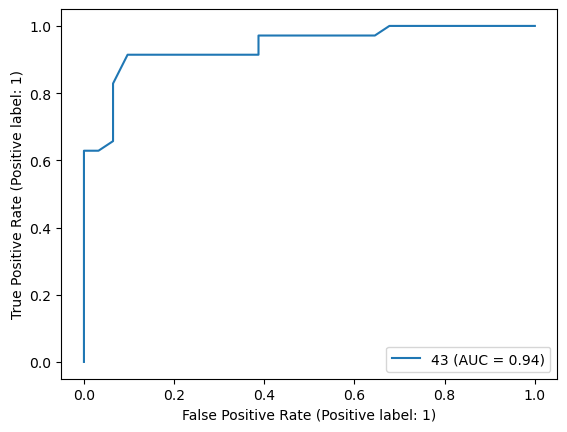

In [10]:
groups = ["qsampled", "runif"]

questions_asked = 43
data = _diss_dataset(diss[0], questions_asked, groups=groups)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
)

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

In [ ]:
groups = ["qsampled", "m2"]
output_path = "data/classification/ptsd/core/"
name = f"rf_{groups[1]}_core_random_order"

auc_dfs = list()
plot = False
retrains = 3
n_trials = 50
question_iter = range(1, 102, 5)

classifier = RandomForestClassifier(n_jobs=-1)
# classifier = lgb.LGBMClassifier()


# for each dissonance file
for d in tqdm(diss, desc="Dissonance files"):
    # repeat performance calc
    for _ in tqdm(range(retrains), desc="Training cycles this file"):
        fig, ax = plt.subplots()
        aucs = list()
        z_aucs = list()
        z_aucs_lb = list()
        z_aucs_ub = list()
        roc_dfs = list()

        # which computes the auc for classifier at each question marker
        for questions_asked in question_iter:
            data = _diss_dataset(d, questions_asked, groups=groups)
            X_train, X_test, y_train, y_test = train_test_split(
                data.drop("y", axis="columns"), data["y"], test_size=0.33
            )

            # X_train = X_train.mean(axis=1)
            # X_test = X_test.mean(axis=1)

            def objective(trial):
                # pruning_callback = optuna.integration.LightGBMPruningCallback(
                #    trial, "auc"
                # )

                param = {
                    "n_estimators": trial.suggest_int("n_estimators", 50, 250),
                    "max_depth": trial.suggest_int("max_depth", 5, 15),
                    "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
                }

                classifier.set_params(**param)
                classifier.fit(
                    X_train.to_numpy(),
                    y_train.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    # callbacks=[pruning_callback],
                )

                r = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test.to_numpy(),
                    y_test.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    pos_label=1,
                    ax=ax,
                    name=questions_asked,
                )

                return r.roc_auc

            study = optuna.create_study(
                # pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                direction="maximize",
            )
            func = lambda trial: objective(trial, param)
            study.optimize(objective, n_trials=n_trials)

            classifier.set_params(**study.best_trial.params)
            classifier.fit(
                X_train.to_numpy(),
                y_train.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
            )

            r = RocCurveDisplay.from_estimator(
                classifier,
                X_test.to_numpy(),
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                pos_label=1,
                ax=ax,
                name=questions_asked,
            )
            aucs.append(r.roc_auc)
            fpr, tpr, thresholds = roc_curve(
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                classifier.predict_proba(X_test.to_numpy())[:, 1],
                pos_label=1,
            )
            roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
            roc_dfs.append(roc_df.assign(questions=questions_asked))
            if plot is False:
                plt.close()

            try:
                zt = zedstat.processRoc(
                    roc_df,
                    order=3,
                    total_samples=1000,
                    positive_samples=150,
                    alpha=0.01,
                    prevalence=0.15,
                )

                zt.smooth(STEP=0.01)
                zt.allmeasures(interpolate=False)
                zt.usample(precision=3)
                zt.getBounds()
                z_aucs.append(zt.auc()[0])
                z_aucs_lb.append(zt.auc()[2])
                z_aucs_ub.append(zt.auc()[1])
            except:
                z_aucs.append(r.roc_auc)
                z_aucs_lb.append(r.roc_auc)
                z_aucs_ub.append(r.roc_auc)

        auc_df = pd.DataFrame(
            {
                "questions asked": question_iter,
                "auc": aucs,
                "z_auc": z_aucs,
                "z_auc_lb": z_aucs_lb,
                "z_auc_ub": z_aucs_ub,
            }
        )

        if plot is True:
            ax = auc_df.plot(x="questions asked", y="z_auc")
            ax.fill_between(
                auc_df["questions asked"],
                auc_df["z_auc_ub"],
                auc_df["z_auc_lb"],
                alpha=0.25,
            )

        time = str(datetime.now())

        pd.concat(roc_dfs).to_csv(
            f"{output_path}roc_df_rf_{name}_{time}.csv",
            index=False,
        )
        auc_dfs.append(auc_df)
        auc_df.to_csv(
            f"{output_path}auc_df_rf_{name}_{time}.csv",
            index=False,
        )
    pd.concat(auc_dfs).groupby(level=0).mean().to_csv(
        f"{output_path}auc_dfs_rf_{name}_{datetime.now()}.csv",
        index=False,
    )

In [12]:
conf = 0.95

rf_res = pd.concat(
    [pd.read_csv(df) for df in glob.glob(f"{output_path}auc_df_rf_{name}_*.csv")]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

,questions asked,mean,var,lower,upper
0,1,0.628619,0.004293,0.604153,0.653084
1,6,0.831197,0.002566,0.812280,0.850113
2,11,0.881533,0.001724,0.866031,0.897036
3,16,0.902004,0.001323,0.888423,0.915585
4,21,0.933901,0.000991,0.922149,0.945653
5,26,0.953393,0.000447,0.945500,0.961286
6,31,0.962656,0.000348,0.955687,0.969626
7,36,0.961663,0.000344,0.954742,0.968583
8,41,0.972189,0.000384,0.964870,0.979509
9,46,0.978810,0.000384,0.971495,0.986125


In [13]:
results_path = "data/classification/ptsd/core/results/"

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(f"{results_path}results_{name}.csv", index=False)

In [14]:
groups = ["qsampled", "m2"]
output_path = "data/classification/ptsd/core/"
name = f"rf_{groups[1]}_core_random_order"
results_path = "data/classification/ptsd/core/results/"

df = pd.read_csv(f"{results_path}results_{name}.csv")

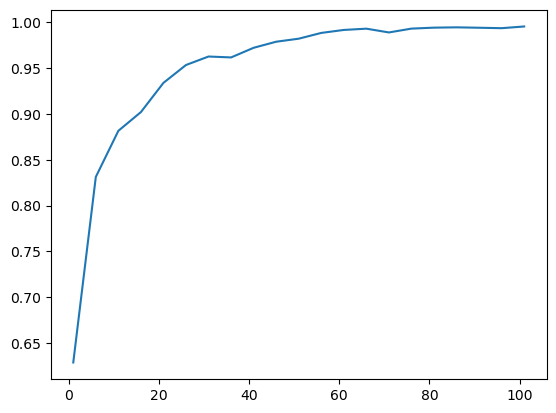

In [15]:
plt.plot(df["questions asked"], df["mean"])

### New

In [3]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob("disson_new/ptsd/core/disson_ptsd_qmra/random_order_disson*.pkl")
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob("disson_new/ptsd/core/disson_ptsd_qmra/random_order_disson*.pkl")
]

In [4]:
len(diss)

10

In [ ]:
groups = ["qsampled", "m2"]
output_path = "data/classification/new/ptsd/core/"
name = f"rf_{groups[1]}_core_random_order"

auc_dfs = list()
plot = False
retrains = 3
n_trials = 50
question_iter = range(1, 102, 5)

classifier = RandomForestClassifier(n_jobs=-1)
# classifier = lgb.LGBMClassifier()


# for each dissonance file
for d in tqdm(diss, desc="Dissonance files"):
    # repeat performance calc
    for _ in tqdm(range(retrains), desc="Training cycles this file"):
        fig, ax = plt.subplots()
        aucs = list()
        z_aucs = list()
        z_aucs_lb = list()
        z_aucs_ub = list()
        roc_dfs = list()

        # which computes the auc for classifier at each question marker
        for questions_asked in question_iter:
            data = _diss_dataset(d, questions_asked, groups=groups)
            X_train, X_test, y_train, y_test = train_test_split(
                data.drop("y", axis="columns"), data["y"], test_size=0.33
            )

            # X_train = X_train.mean(axis=1)
            # X_test = X_test.mean(axis=1)

            def objective(trial):
                # pruning_callback = optuna.integration.LightGBMPruningCallback(
                #    trial, "auc"
                # )

                param = {
                    "n_estimators": trial.suggest_int("n_estimators", 50, 250),
                    "max_depth": trial.suggest_int("max_depth", 5, 15),
                    "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
                }

                classifier.set_params(**param)
                classifier.fit(
                    X_train.to_numpy(),
                    y_train.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    # callbacks=[pruning_callback],
                )

                r = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test.to_numpy(),
                    y_test.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    pos_label=1,
                    ax=ax,
                    name=questions_asked,
                )

                return r.roc_auc

            study = optuna.create_study(
                # pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                direction="maximize",
            )
            func = lambda trial: objective(trial, param)
            study.optimize(objective, n_trials=n_trials)

            classifier.set_params(**study.best_trial.params)
            classifier.fit(
                X_train.to_numpy(),
                y_train.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
            )

            r = RocCurveDisplay.from_estimator(
                classifier,
                X_test.to_numpy(),
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                pos_label=1,
                ax=ax,
                name=questions_asked,
            )
            aucs.append(r.roc_auc)
            fpr, tpr, thresholds = roc_curve(
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                classifier.predict_proba(X_test.to_numpy())[:, 1],
                pos_label=1,
            )
            roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
            roc_dfs.append(roc_df.assign(questions=questions_asked))
            if plot is False:
                plt.close()

            try:
                zt = zedstat.processRoc(
                    roc_df,
                    order=3,
                    total_samples=1000,
                    positive_samples=150,
                    alpha=0.01,
                    prevalence=0.15,
                )

                zt.smooth(STEP=0.01)
                zt.allmeasures(interpolate=False)
                zt.usample(precision=3)
                zt.getBounds()
                z_aucs.append(zt.auc()[0])
                z_aucs_lb.append(zt.auc()[2])
                z_aucs_ub.append(zt.auc()[1])
            except:
                z_aucs.append(r.roc_auc)
                z_aucs_lb.append(r.roc_auc)
                z_aucs_ub.append(r.roc_auc)

        auc_df = pd.DataFrame(
            {
                "questions asked": question_iter,
                "auc": aucs,
                "z_auc": z_aucs,
                "z_auc_lb": z_aucs_lb,
                "z_auc_ub": z_aucs_ub,
            }
        )

        if plot is True:
            ax = auc_df.plot(x="questions asked", y="z_auc")
            ax.fill_between(
                auc_df["questions asked"],
                auc_df["z_auc_ub"],
                auc_df["z_auc_lb"],
                alpha=0.25,
            )

        time = str(datetime.now())

        pd.concat(roc_dfs).to_csv(
            f"{output_path}roc_df_rf_{name}_{time}.csv",
            index=False,
        )
        auc_dfs.append(auc_df)
        auc_df.to_csv(
            f"{output_path}auc_df_rf_{name}_{time}.csv",
            index=False,
        )
    pd.concat(auc_dfs).groupby(level=0).mean().to_csv(
        f"{output_path}auc_dfs_rf_{name}_{datetime.now()}.csv",
        index=False,
    )

In [4]:
groups = ["qsampled", "m2"]
output_path = "data/classification/new/ptsd/core/"
name = f"rf_{groups[1]}_core_random_order"

len([pd.read_csv(df) for df in glob.glob(f"{output_path}auc_df_rf_{name}_*.csv")])

30

In [5]:
conf = 0.95

rf_res = pd.concat(
    [pd.read_csv(df) for df in glob.glob(f"{output_path}auc_df_rf_{name}_*.csv")]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

,questions asked,mean,var,lower,upper
0,1,0.650538,0.004036,0.626814,0.674261
1,6,0.844215,0.001779,0.828465,0.859965
2,11,0.919035,0.001612,0.904045,0.934026
3,16,0.944955,0.000443,0.937098,0.952813
4,21,0.960292,0.000428,0.952564,0.968021
5,26,0.969393,0.000204,0.964060,0.974725
6,31,0.977404,0.000235,0.971681,0.983126
7,36,0.986539,0.000151,0.981953,0.991126
8,41,0.991382,0.000052,0.988689,0.994075
9,46,0.991536,0.000084,0.988121,0.994951


In [ ]:
results_path = "data/classification/new/ptsd/core/results/"

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(f"{results_path}results_{name}.csv", index=False)

In [ ]:
rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(f"{results_path}results_{name}.csv", index=False)

Text(0.5, 1.0, 'PTSD Core')

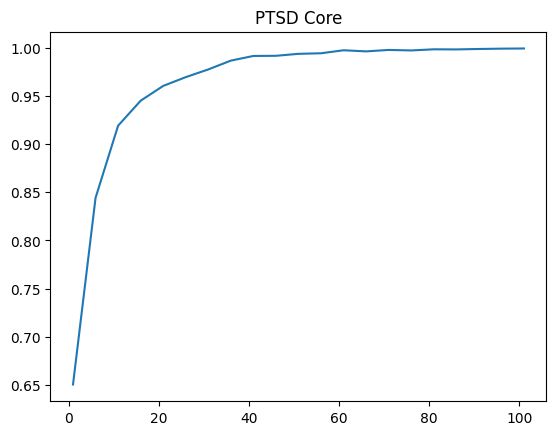

In [8]:
results_path = "data/classification/new/ptsd/core/results/"
df = pd.read_csv(f"{results_path}results_{name}.csv")

plt.plot(
    df["questions asked"],
    df["mean"],
)
plt.title("PTSD Core")

## Dx sampling classification

### Old

In [3]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob("disson_ptsd/disson_ptsd_qmra_random_order_disson*.pkl")
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob("disson_ptsd/disson_ptsd_qmra_random_order_samples*.pkl")
]

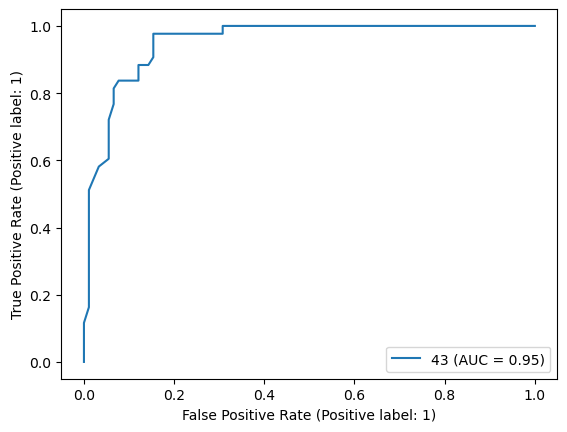

In [6]:
groups = ["actual", "m2"]

questions_asked = 43
data = _diss_dataset(diss[0], questions_asked, groups=groups)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
)

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

In [8]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob("disson_new/ptsd/dx/disson_ptsd_qmra/random_order_disson*.pkl")
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob("disson_new/ptsd/dx/disson_ptsd_qmra/random_order_samples*.pkl")
]

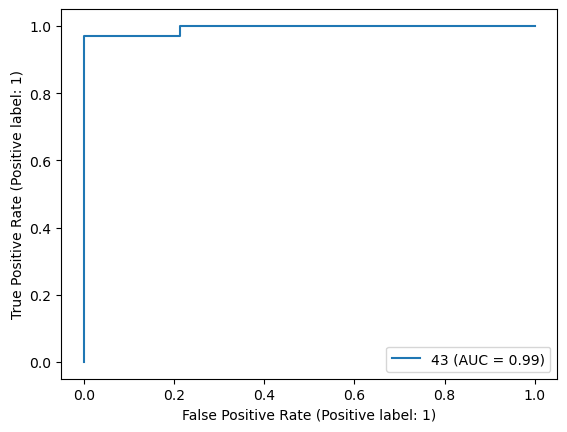

In [11]:
groups = ["qsampled", "m2"]

questions_asked = 43
data = _diss_dataset(diss[0], questions_asked, groups=groups)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
)

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

### New

In [ ]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob("disson_new/ptsd/dx/disson_ptsd_qmra/random_order_disson*.pkl")
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob("disson_new/ptsd/dx/disson_ptsd_qmra/random_order_disson*.pkl")
]

groups = ["qsampled", "m2"]
output_path = "data/classification/new/ptsd/dx/"
name = f"rf_{groups[1]}_core_random_order"

auc_dfs = list()
plot = False
retrains = 3
n_trials = 50
question_iter = range(1, 102, 5)

classifier = RandomForestClassifier(n_jobs=-1)
# classifier = lgb.LGBMClassifier()


# for each dissonance file
for d in tqdm(diss, desc="Dissonance files"):
    # repeat performance calc
    for _ in tqdm(range(retrains), desc="Training cycles this file"):
        fig, ax = plt.subplots()
        aucs = list()
        z_aucs = list()
        z_aucs_lb = list()
        z_aucs_ub = list()
        roc_dfs = list()

        # which computes the auc for classifier at each question marker
        for questions_asked in question_iter:
            data = _diss_dataset(d, questions_asked, groups=groups)
            X_train, X_test, y_train, y_test = train_test_split(
                data.drop("y", axis="columns"), data["y"], test_size=0.33
            )

            # X_train = X_train.mean(axis=1)
            # X_test = X_test.mean(axis=1)

            def objective(trial):
                # pruning_callback = optuna.integration.LightGBMPruningCallback(
                #    trial, "auc"
                # )

                param = {
                    "n_estimators": trial.suggest_int("n_estimators", 50, 250),
                    "max_depth": trial.suggest_int("max_depth", 5, 15),
                    "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
                }

                classifier.set_params(**param)
                classifier.fit(
                    X_train.to_numpy(),
                    y_train.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    # callbacks=[pruning_callback],
                )

                r = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test.to_numpy(),
                    y_test.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    pos_label=1,
                    ax=ax,
                    name=questions_asked,
                )

                return r.roc_auc

            study = optuna.create_study(
                # pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                direction="maximize",
            )
            func = lambda trial: objective(trial, param)
            study.optimize(objective, n_trials=n_trials)

            classifier.set_params(**study.best_trial.params)
            classifier.fit(
                X_train.to_numpy(),
                y_train.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
            )

            r = RocCurveDisplay.from_estimator(
                classifier,
                X_test.to_numpy(),
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                pos_label=1,
                ax=ax,
                name=questions_asked,
            )
            aucs.append(r.roc_auc)
            fpr, tpr, thresholds = roc_curve(
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                classifier.predict_proba(X_test.to_numpy())[:, 1],
                pos_label=1,
            )
            roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
            roc_dfs.append(roc_df.assign(questions=questions_asked))
            if plot is False:
                plt.close()

            try:
                zt = zedstat.processRoc(
                    roc_df,
                    order=3,
                    total_samples=1000,
                    positive_samples=150,
                    alpha=0.01,
                    prevalence=0.15,
                )

                zt.smooth(STEP=0.01)
                zt.allmeasures(interpolate=False)
                zt.usample(precision=3)
                zt.getBounds()
                z_aucs.append(zt.auc()[0])
                z_aucs_lb.append(zt.auc()[2])
                z_aucs_ub.append(zt.auc()[1])
            except:
                z_aucs.append(r.roc_auc)
                z_aucs_lb.append(r.roc_auc)
                z_aucs_ub.append(r.roc_auc)

        auc_df = pd.DataFrame(
            {
                "questions asked": question_iter,
                "auc": aucs,
                "z_auc": z_aucs,
                "z_auc_lb": z_aucs_lb,
                "z_auc_ub": z_aucs_ub,
            }
        )

        if plot is True:
            ax = auc_df.plot(x="questions asked", y="z_auc")
            ax.fill_between(
                auc_df["questions asked"],
                auc_df["z_auc_ub"],
                auc_df["z_auc_lb"],
                alpha=0.25,
            )

        time = str(datetime.now())

        pd.concat(roc_dfs).to_csv(
            f"{output_path}roc_df_rf_{name}_{time}.csv",
            index=False,
        )
        auc_dfs.append(auc_df)
        auc_df.to_csv(
            f"{output_path}auc_df_rf_{name}_{time}.csv",
            index=False,
        )
    pd.concat(auc_dfs).groupby(level=0).mean().to_csv(
        f"{output_path}auc_dfs_rf_{name}_{datetime.now()}.csv",
        index=False,
    )

Text(0.5, 1.0, 'PTSD Dx')

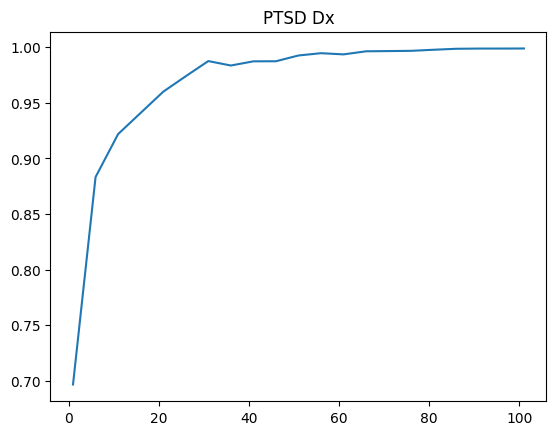

In [14]:
conf = 0.95
output_path = "data/classification/new/ptsd/dx/"
results_path = "data/classification/new/ptsd/dx/results/"

rf_res = pd.concat(
    [pd.read_csv(df) for df in glob.glob(f"{output_path}auc_df_rf_{name}_*.csv")]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(f"{results_path}results_{name}.csv", index=False)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(f"{results_path}results_{name}.csv", index=False)

df = pd.read_csv(f"{results_path}results_{name}.csv")

plt.plot(
    df["questions asked"],
    df["mean"],
)
plt.title("PTSD Dx")

# Global

## Core sampling:

### Old

In [ ]:
_save_sampling_scenarios(
    iter=range(1, 10),
    df=pd.read_csv("data/gibbons_global/gibbons_global.csv"),
    name="disson_global/core/disson_global_core",
    diss_file=None,
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
)

With actual added:

In [11]:
_save_sampling_scenarios(
    iter=range(1, 4),
    df=pd.read_csv("data/gibbons_global/gibbons_global.csv"),
    name="disson_global/core/disson_global_core_with_actual_ff",
    diss_file=None,
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
)

  0%|          | 0/3 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ncsizemore/opt/anaconda3/envs/pkgs/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/ncsizemore/opt/anaconda3/envs/pkgs/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
_pickle.UnpicklingError: pickle data was truncated


### New

In [ ]:
_save_sampling_scenarios(
    iter=range(1,10),
    df=pd.read_csv("data/gibbons_global/gibbons_global.csv"),
    name="disson_new/global/core/disson_global_qmra_missing_nan",
    diss_file=None,
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
    missing_value=np.nan,
    m2_method="unconditional",
)

In [7]:
_save_sampling_scenarios(
    iter=range(10),
    df=pd.read_csv("data/gibbons_global/gibbons_global.csv"),
    name="disson_new/global/core/disson_global_qmra_missing_0",
    diss_file=None,
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
    missing_value=0,
    m2_method="unconditional",
)

  0%|          | 0/10 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1236 [00:00<?, ?it/s]

  0%|          | 0/1236 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1236 [00:00<?, ?it/s]

  0%|          | 0/1236 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1236 [00:00<?, ?it/s]

  0%|          | 0/1236 [00:00<?, ?it/s]

## Dx sampling:

### Old

In [ ]:
_save_sampling_scenarios(
    iter=range(1, 2),
    df=pd.read_csv("data/gibbons_global/gibbons_global.csv"),
    df_pos=pd.read_csv("data/gibbons_global/gibbons_global_pos.csv"),
    df_neg=pd.read_csv("data/gibbons_global/gibbons_global_neg.csv"),
    name="disson_global/disson_global_qmra",
    diss_file="mpi_tmp/global_dissonance.csv",
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
)

### New

In [ ]:
_save_sampling_scenarios(
    iter=range(10),
    df=pd.read_csv("data/gibbons_global/gibbons_global.csv"),
    df_pos=pd.read_csv("data/gibbons_global/gibbons_global_pos.csv"),
    df_neg=pd.read_csv("data/gibbons_global/gibbons_global_neg.csv"),
    name="disson_new/global/dx/disson_global_qmra_missing_0",
    diss_file=None,
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
    missing_value=np.nan,
    m2_method="unconditional",
)

### Debugging

In [34]:
def _get_tnets(
    df,
    df_pos=None,
    df_neg=None,
    diss_file=None,
    suspects=None,
    alpha=0.01,
):
    if df_pos is not None and df_neg is not None:
        non_null_cols = (
            (df.isna().sum() < len(df))
            & (df_pos.isna().sum() < len(df_pos))
            & (df_neg.isna().sum() < len(df_neg))
        )

        df_fmtd = df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        df_pos_fmtd = (
            df_pos.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )
        df_neg_fmtd = (
            df_neg.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )
        df_fmtd.to_csv("df_tmp.csv", index=False)
        df_pos_fmtd.to_csv("df_pos_tmp.csv", index=False)
        df_neg_fmtd.to_csv("df_neg_tmp.csv", index=False)

        if suspects is not None:
            Tr = truthnet()

            Tr_pos = truthnet()
            features, samples = Tr.load_data(datapath="df_tmp.csv")
            features_pos, samples_pos = Tr_pos.load_data(datapath="df_pos_tmp.csv")
            Tr.fit(modelpath="tmp_Qnet.joblib")
            Tr_pos.fit(modelpath="tmp_Qnet_pos.joblib")
            if diss_file is not None:
                Tr.dissonance = pd.read_csv(diss_file)
            else:
                Tr.getDissonance(outfile="data/tmp_dissonance_matrix.csv")
                Tr_pos.getDissonance(outfile="data/tmp_dissonance_matrix_pos.csv")
            for alpha in [0.01, 0.05, 0.1]:
                Tr.getSuspects(alpha=alpha).to_csv(f"{suspects}_full_model_{alpha}.csv")
                Tr_pos.getSuspects(alpha=alpha).to_csv(
                    f"{suspects}_pos_model_{alpha}.csv"
                )

        Tr = _get_qnet(df_fmtd)
        Tr_pos = _get_qnet(df_pos_fmtd)
        Tr_neg = _get_qnet(df_neg_fmtd)
    else:
        Tr = truthnet()
        length = sum(df.isna().sum() < len(df))
        df.fillna(-9).astype(int).replace(-9, "").to_csv("tmpfile.csv", index=False)
        features, samples = Tr.load_data(datapath="tmpfile.csv")
        Tr.fit(modelpath="tmp_Qnet.joblib")
        if diss_file is not None:
            Tr.dissonance = pd.read_csv(diss_file)
        else:
            Tr.getDissonance(outfile="data/tmp_dissonance_matrix.csv")
        if suspects is not None:
            for alpha in [0.01, 0.05, 0.1]:
                Tr.getSuspects(alpha=alpha).to_csv(f"{suspects}_{alpha}.csv")
        coresamples = Tr.getCoresamples(alpha=alpha, steps=length)
        df_pos = df.loc[coresamples.index.values]
        if len(coresamples) == len(df):
            df_neg = None
            non_null_cols = (df.isna().sum() < len(df)) & (
                df_pos.isna().sum() < len(df_pos)
            )
            Tr_neg = None
            Tr = _get_qnet(
                df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
            )
            Tr_pos = Tr

        else:
            df_neg = df.loc[~df.index.isin(coresamples.index.values)]

            non_null_cols = (
                (df.isna().sum() < len(df))
                & (df_pos.isna().sum() < len(df_pos))
                & (df_neg.isna().sum() < len(df_neg))
            )

            Tr = _get_qnet(
                df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
            )
            Tr_pos = _get_qnet(
                df_pos.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
            )
            Tr_neg = _get_qnet(
                df_neg.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
            )

    return {
        "all": Tr,
        "pos": Tr_pos,
        "neg": Tr_neg,
        "data": df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, ""),
        # "core": coresamples,
    }

In [35]:
tng = _get_tnets(
    df=pd.read_csv("data/gibbons_global/gibbons_global.csv"),
    diss_file="mpi_tmp/global_dissonance.csv",
)

QUEUEING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1236 [00:00<?, ?it/s]

In [18]:
df = pd.read_csv("data/gibbons_global/gibbons_global.csv")
df_pos = df.loc[coresamples.index.values]
df_neg = df.loc[~df.index.isin(coresamples.index.values)]

non_null_cols = (
    (df.isna().sum() < len(df))
    & (df_pos.isna().sum() < len(df_pos))
    & (df_neg.isna().sum() < len(df_neg))
)

In [23]:
(df.isna().sum() < len(df)).sum()

390

In [22]:
(df_pos.isna().sum() < len(df_pos)).sum()

390

In [24]:
(df_neg.isna().sum() < len(df_neg)).sum()

0

In [19]:
non_null_cols

2       False
3       False
5       False
6       False
7       False
        ...  
4632    False
4634    False
4635    False
4636    False
4637    False
Length: 424, dtype: bool

In [17]:
coresamples = tng["core"]

In [12]:
full_model = tng["all"]
pos_model = tng["pos"]
neg_model = tng["neg"]

if neg_model is not None:
    diss_models = [full_model, neg_model, pos_model]
else:
    diss_models = [full_model, pos_model]
ds = tng["data"].head(3)

In [36]:
tng["data"]

,2,3,5,6,7,8,9,10,11,12,...,4590,4591,4592,4593,4594,4596,4631,4632,4634,4635
0,,,,,,,,,,,...,,,,,,,,,,
1,,,,,,1,,,,,...,,,,,,,,,,
2,,,,,,,,,,,...,3,,,,,3,,,,
3,,,,1,,,,1,,,...,,,,,,3,,,,
4,,,1,1,,,,,,,...,1,,,,,1,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,,,,2,,,,,,,...,3,,,,,5,,,,
1232,,,1,,,,1,,,,...,2,,,,,3,,,,
1233,,,,,,,,,1,,...,1,,,,,4,,,,
1234,,,2,,,,2,,,,...,,,,,,2,,,2,


In [13]:
ds.head(3)

""
0
1
2


In [14]:
ds

,2,3,5,6,7,8,9,10,11,12,...,4592,4593,4594,4596,4631,4632,4634,4635,4636,4637
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
ds

,2,3,5,6,7,8,9,10,11,12,...,4590,4591,4592,4593,4594,4596,4631,4632,4634,4635
0,,,,,,,,,,,...,,,,,,,,,,
1,,,,,,1,,,,,...,,,,,,,,,,
2,,,,,,,,,,,...,3,,,,,3,,,,


In [39]:
Ds = tng["all"].predict_distributions(s)
Ds[0].keys()

dict_keys(['2', '1'])

In [43]:
s = ds.to_numpy()[0]
ss = np.full_like(s, fill_value="")
_diss_linear(ss, tng["all"])

array([], dtype=float64)

In [41]:
ss

array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', ''

In [38]:
s.shape

(346,)

In [35]:
ds.to_numpy()[0]

array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 1,
       '', '', '', 2, '', '', '', 1, '', '', '', '', '', '', '', '', 2,
       '', '', '', '', '', '', '', 1, '', '', '', '', '', '', '', '', '',
       '', '', '', 1, '', '', '', 1, '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', 1, '', '', 2, '', '', '', '', '', '', '',
       2, '', 3, '', '', '', '', '', 2, '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', 2, '', '', 2, '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', 4, '', '', '', '',
       '', '', '', '', 3, '', '', '', '', '', '', '', '', '', 2, '', '',
       2, '', '', '', 2, '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', 2, '', '', '', '', '', '', 2, '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', 1, '', '', '',
       '', '', '', '', '', '', '', 2, '', '', '

In [54]:
sample.dtype

dtype('<U1')

In [55]:
sample = np.full(100, "", dtype="<U21")

In [53]:
arr = np.array(["", "", ""], dtype="U16")

# Assign a string value to an element of the array
arr[0] = "Hello"

print(arr)

['Hello' '' '']


In [56]:
sample[0] = "missing"
sample

array(['missing', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
      dtype='<U21')

In [ ]:
s, d = _all_actual_samples_dissonance(
    ds.to_numpy(), diss_models, _diss_linear, None, 346
)

In [59]:
d[0]

[[array([0]),
  array([0, 0]),
  array([0, 0, 0]),
  array([0, 0, 0, 0]),
  array([0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  array([0.        , 0.        , 0.        , 0.  

In [ ]:
groups = ["qsampled", "runif"]

questions_asked = 43
data = _diss_dataset(d[0], questions_asked, groups=groups)

In [32]:
d[0][0][0]

array([], dtype=float64)

## Core sampling classification

### Old

In [8]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob("disson_global/core/disson_global_core_random_order_disson*.pkl")
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_global/core/disson_global_core_random_order_samples*.pkl"
    )
]

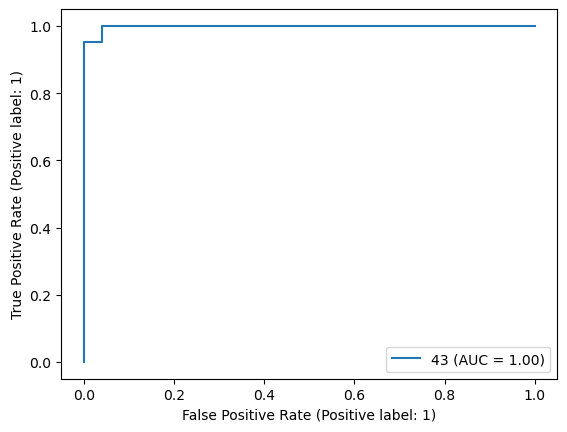

In [9]:
groups = ["qsampled", "runif"]

questions_asked = 43
data = _diss_dataset(diss[0], questions_asked, groups=groups)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
)

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

In [5]:
diss = pd.read_pickle(
    "disson_global/core/disson_global_core_with_actual_ff_random_order_disson_1.pkl"
)

In [ ]:
diss["runif"]

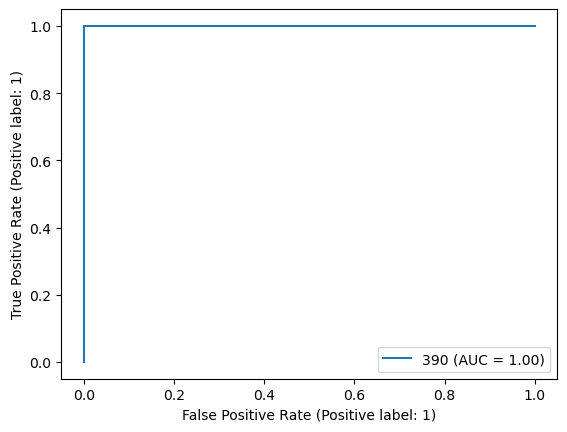

In [11]:
groups = ["qsampled", "runif"]

questions_asked = 390
data = _diss_dataset(diss, questions_asked, groups=groups)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
)

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

In [ ]:
groups = ["qsampled", "m2"]
output_path = "data/classification/global/core/"
name = f"rf_{groups[1]}_core_random_order"

auc_dfs = list()
plot = False
retrains = 3
n_trials = 50
question_iter = range(1, 102, 5)

classifier = RandomForestClassifier(n_jobs=-1)
# classifier = lgb.LGBMClassifier()


# for each dissonance file
for d in tqdm(diss, desc="Dissonance files"):
    # repeat performance calc
    for _ in tqdm(range(retrains), desc="Training cycles this file"):
        fig, ax = plt.subplots()
        aucs = list()
        z_aucs = list()
        z_aucs_lb = list()
        z_aucs_ub = list()
        roc_dfs = list()

        # which computes the auc for classifier at each question marker
        for questions_asked in question_iter:
            data = _diss_dataset(d, questions_asked, groups=groups)
            X_train, X_test, y_train, y_test = train_test_split(
                data.drop("y", axis="columns"), data["y"], test_size=0.33
            )

            # X_train = X_train.mean(axis=1)
            # X_test = X_test.mean(axis=1)

            def objective(trial):
                # pruning_callback = optuna.integration.LightGBMPruningCallback(
                #    trial, "auc"
                # )

                param = {
                    "n_estimators": trial.suggest_int("n_estimators", 50, 250),
                    "max_depth": trial.suggest_int("max_depth", 5, 15),
                    "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
                }

                classifier.set_params(**param)
                classifier.fit(
                    X_train.to_numpy(),
                    y_train.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    # callbacks=[pruning_callback],
                )

                r = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test.to_numpy(),
                    y_test.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    pos_label=1,
                    ax=ax,
                    name=questions_asked,
                )

                return r.roc_auc

            study = optuna.create_study(
                # pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                direction="maximize",
            )
            func = lambda trial: objective(trial, param)
            study.optimize(objective, n_trials=n_trials)

            classifier.set_params(**study.best_trial.params)
            classifier.fit(
                X_train.to_numpy(),
                y_train.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
            )

            r = RocCurveDisplay.from_estimator(
                classifier,
                X_test.to_numpy(),
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                pos_label=1,
                ax=ax,
                name=questions_asked,
            )
            aucs.append(r.roc_auc)
            fpr, tpr, thresholds = roc_curve(
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                classifier.predict_proba(X_test.to_numpy())[:, 1],
                pos_label=1,
            )
            roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
            roc_dfs.append(roc_df.assign(questions=questions_asked))
            if plot is False:
                plt.close()

            try:
                zt = zedstat.processRoc(
                    roc_df,
                    order=3,
                    total_samples=1000,
                    positive_samples=150,
                    alpha=0.01,
                    prevalence=0.15,
                )

                zt.smooth(STEP=0.01)
                zt.allmeasures(interpolate=False)
                zt.usample(precision=3)
                zt.getBounds()
                z_aucs.append(zt.auc()[0])
                z_aucs_lb.append(zt.auc()[2])
                z_aucs_ub.append(zt.auc()[1])
            except:
                z_aucs.append(r.roc_auc)
                z_aucs_lb.append(r.roc_auc)
                z_aucs_ub.append(r.roc_auc)

        auc_df = pd.DataFrame(
            {
                "questions asked": question_iter,
                "auc": aucs,
                "z_auc": z_aucs,
                "z_auc_lb": z_aucs_lb,
                "z_auc_ub": z_aucs_ub,
            }
        )

        if plot is True:
            ax = auc_df.plot(x="questions asked", y="z_auc")
            ax.fill_between(
                auc_df["questions asked"],
                auc_df["z_auc_ub"],
                auc_df["z_auc_lb"],
                alpha=0.25,
            )

        time = str(datetime.now())

        pd.concat(roc_dfs).to_csv(
            f"{output_path}roc_df_rf_{name}_{time}.csv",
            index=False,
        )
        auc_dfs.append(auc_df)
        auc_df.to_csv(
            f"{output_path}auc_df_rf_{name}_{time}.csv",
            index=False,
        )
    pd.concat(auc_dfs).groupby(level=0).mean().to_csv(
        f"{output_path}auc_dfs_rf_{name}_{datetime.now()}.csv",
        index=False,
    )

In [ ]:
conf = 0.95

rf_res = pd.concat(
    [pd.read_csv(df) for df in glob.glob(f"{output_path}auc_df_rf_{name}_*.csv")]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

In [ ]:
results_path = "data/classification/global/core/results/"

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(f"{results_path}results_{name}.csv", index=False)

In [ ]:
groups = ["qsampled", "m2"]
output_path = "data/classification/ptsd/core/"
name = f"rf_{groups[1]}_core_random_order"
results_path = "data/classification/ptsd/core/results/"

df = pd.read_csv(f"{results_path}results_{name}.csv")

plt.plot(df["questions asked"], df["mean"])

### New

In [ ]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_new/global/core/disson_global_qmra/random_order_disson*.pkl"
    )
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_new/global/core/disson_global_qmra/random_order_samples*.pkl"
    )
]

groups = ["qsampled", "m2"]
output_path = "data/classification/new/global/core/"
name = f"rf_{groups[1]}_core_random_order"

auc_dfs = list()
plot = False
retrains = 3
n_trials = 50
question_iter = range(1, 102, 5)

classifier = RandomForestClassifier(n_jobs=-1)
# classifier = lgb.LGBMClassifier()


# for each dissonance file
for d in tqdm(diss, desc="Dissonance files"):
    # repeat performance calc
    for _ in tqdm(range(retrains), desc="Training cycles this file"):
        fig, ax = plt.subplots()
        aucs = list()
        z_aucs = list()
        z_aucs_lb = list()
        z_aucs_ub = list()
        roc_dfs = list()

        # which computes the auc for classifier at each question marker
        for questions_asked in question_iter:
            data = _diss_dataset(d, questions_asked, groups=groups)
            X_train, X_test, y_train, y_test = train_test_split(
                data.drop("y", axis="columns"), data["y"], test_size=0.33
            )

            # X_train = X_train.mean(axis=1)
            # X_test = X_test.mean(axis=1)

            def objective(trial):
                # pruning_callback = optuna.integration.LightGBMPruningCallback(
                #    trial, "auc"
                # )

                param = {
                    "n_estimators": trial.suggest_int("n_estimators", 50, 250),
                    "max_depth": trial.suggest_int("max_depth", 5, 15),
                    "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
                }

                classifier.set_params(**param)
                classifier.fit(
                    X_train.to_numpy(),
                    y_train.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    # callbacks=[pruning_callback],
                )

                r = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test.to_numpy(),
                    y_test.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    pos_label=1,
                    ax=ax,
                    name=questions_asked,
                )

                return r.roc_auc

            study = optuna.create_study(
                # pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                direction="maximize",
            )
            func = lambda trial: objective(trial, param)
            study.optimize(objective, n_trials=n_trials)

            classifier.set_params(**study.best_trial.params)
            classifier.fit(
                X_train.to_numpy(),
                y_train.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
            )

            r = RocCurveDisplay.from_estimator(
                classifier,
                X_test.to_numpy(),
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                pos_label=1,
                ax=ax,
                name=questions_asked,
            )
            aucs.append(r.roc_auc)
            fpr, tpr, thresholds = roc_curve(
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                classifier.predict_proba(X_test.to_numpy())[:, 1],
                pos_label=1,
            )
            roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
            roc_dfs.append(roc_df.assign(questions=questions_asked))
            if plot is False:
                plt.close()

            try:
                zt = zedstat.processRoc(
                    roc_df,
                    order=3,
                    total_samples=1000,
                    positive_samples=150,
                    alpha=0.01,
                    prevalence=0.15,
                )

                zt.smooth(STEP=0.01)
                zt.allmeasures(interpolate=False)
                zt.usample(precision=3)
                zt.getBounds()
                z_aucs.append(zt.auc()[0])
                z_aucs_lb.append(zt.auc()[2])
                z_aucs_ub.append(zt.auc()[1])
            except:
                z_aucs.append(r.roc_auc)
                z_aucs_lb.append(r.roc_auc)
                z_aucs_ub.append(r.roc_auc)

        auc_df = pd.DataFrame(
            {
                "questions asked": question_iter,
                "auc": aucs,
                "z_auc": z_aucs,
                "z_auc_lb": z_aucs_lb,
                "z_auc_ub": z_aucs_ub,
            }
        )

        if plot is True:
            ax = auc_df.plot(x="questions asked", y="z_auc")
            ax.fill_between(
                auc_df["questions asked"],
                auc_df["z_auc_ub"],
                auc_df["z_auc_lb"],
                alpha=0.25,
            )

        time = str(datetime.now())

        pd.concat(roc_dfs).to_csv(
            f"{output_path}roc_df_rf_{name}_{time}.csv",
            index=False,
        )
        auc_dfs.append(auc_df)
        auc_df.to_csv(
            f"{output_path}auc_df_rf_{name}_{time}.csv",
            index=False,
        )
    pd.concat(auc_dfs).groupby(level=0).mean().to_csv(
        f"{output_path}auc_dfs_rf_{name}_{datetime.now()}.csv",
        index=False,
    )

Text(0.5, 1.0, 'Global core')

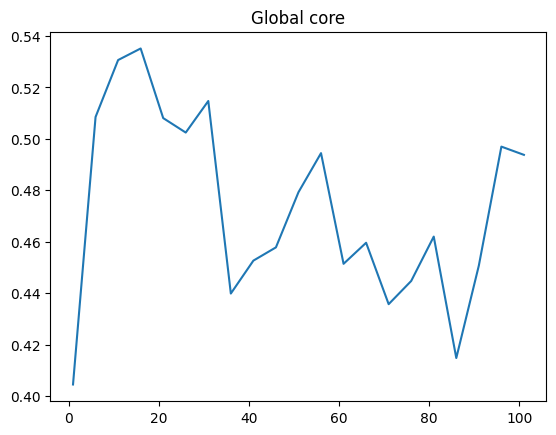

In [13]:
conf = 0.95

groups = ["qsampled", "m2"]
output_path = "data/classification/new/global/core/"
name = f"rf_{groups[1]}_core_random_order"
results_path = "data/classification/new/global/core/results/"

rf_res = pd.concat(
    [pd.read_csv(df) for df in glob.glob(f"{output_path}auc_df_rf_{name}_*.csv")]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

results_path = "data/classification/new/global/core/results/"

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(f"{results_path}results_{name}.csv", index=False)


df = pd.read_csv(f"{results_path}results_{name}.csv")

plt.plot(df["questions asked"], df["mean"])
plt.title("Global core")

## Dx sampling classification

### Old

In [3]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob("disson_global/disson_global_qmra_random_order_disson*.pkl")
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob("disson_global/disson_global_qmra_random_order_samples*.pkl")
]

In [12]:
groups = ["actual", "m2"]

questions_asked = 43
data = _diss_dataset(diss[0], questions_asked, groups=groups)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
)

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1236,) + inhomogeneous part.

In [6]:
_diss_dataset(diss[0], questions_asked, groups=groups)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1236,) + inhomogeneous part.

In [25]:
len(diss[0]["m2"][0][2])

346

In [16]:
diss[0]["actual"][0][0]

[array([], dtype=float64),
 array([], dtype=float64),
 array([0.32291667]),
 array([0.32291667, 0.        ]),
 array([0.32291667, 0.        ]),
 array([0.32291667, 0.        ]),
 array([0.32291667, 0.        ]),
 array([0.32291667, 0.        , 0.99176955]),
 array([0.32291667, 0.        , 0.99176955]),
 array([0.32291667, 0.        , 0.99176955]),
 array([0.32291667, 0.        , 0.99176955]),
 array([0.7831269 , 0.17283951, 0.        , 0.99176955]),
 array([0.7831269 , 0.17283951, 0.        , 0.        , 0.99176955]),
 array([0.7831269 , 0.17283951, 0.        , 0.        , 0.99176955]),
 array([0.7831269 , 0.17283951, 0.        , 0.        , 0.99176955]),
 array([0.7831269 , 0.17283951, 0.        , 0.        , 0.99176955]),
 array([0.7831269 , 0.        , 0.17283951, 0.        , 0.        ,
        0.99176955]),
 array([0.7831269 , 0.        , 0.17283951, 0.        , 0.        ,
        0.99176955]),
 array([0.7831269 , 0.        , 0.17283951, 0.        , 0.        ,
        0.99176955

In [4]:
d = pd.read_pickle(f"disson_ptsd/disson_ptsd_qmra_random_order_disson_{0}.pkl")

In [9]:
len(d["actual"])

304

In [13]:
len(d["runif"])

100

In [31]:
len(d["actual"][0][1][5])

6

In [46]:
d["actual"][0][0][0]

array([0.69767442])

In [47]:
diss[0]["actual"][0][0][0]

array([], dtype=float64)

In [40]:
diss[0]["qsampled"][0][0][10]

array([0.        , 0.8255814 , 0.06557377, 0.        , 0.33333333,
       0.84375   , 0.71428571, 0.        , 0.        , 0.51086957,
       0.        ])

In [15]:
len(diss[0]["qsampled"])

100

In [7]:
len(diss[0])

4

In [8]:
len(d)

4

In [5]:
display(pd.read_csv("data/gibbons_global/gibbons_global.csv"))
display(pd.read_csv("data/gibbons_global/gibbons_global_pos.csv"))
pd.read_csv("data/gibbons_global/gibbons_global_neg.csv")

,2,3,5,6,7,8,9,10,11,12,...,4592,4593,4594,4596,4631,4632,4634,4635,4636,4637
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
1232,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN


,2,3,5,6,7,8,9,10,11,12,...,4592,4593,4594,4596,4631,4632,4634,4635,4636,4637
0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
570,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN
571,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
572,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


,2,3,5,6,7,8,9,10,11,12,...,4592,4593,4594,4596,4631,4632,4634,4635,4636,4637
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4,NaN,NaN,NaN,2.0,NaN,NaN,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
660,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN


In [6]:
display(pd.read_csv("data/ptsd/PTSD_cognet_test_processed.csv"))
display(pd.read_csv("data/ptsd/PTSD_cognet_test_processed_pos_only.csv"))
display(pd.read_csv("data/ptsd/PTSD_cognet_test_processed_neg_only.csv"))

,ptsd1,ptsd2,ptsd3,ptsd4,ptsd5,ptsd6,ptsd7,ptsd8,ptsd9,ptsd10,...,ptsd202,ptsd203,ptsd204,ptsd205,ptsd206,ptsd207,ptsd208,ptsd209,ptsd210,ptsd211
0,4,2,5,4,2,3,2,3,3,2,...,2,4,4,3,2,3,2,2,4,2
1,3,2,3,3,1,3,2,2,2,1,...,3,4,4,3,3,3,4,3,4,5
2,2,2,2,4,1,3,3,2,2,4,...,4,2,2,4,4,2,3,2,2,5
3,2,2,5,1,3,2,1,2,2,1,...,1,2,3,3,3,2,1,1,2,2
4,4,1,1,1,2,2,1,1,1,2,...,2,2,2,2,1,1,2,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,4,2,3,4,1,1,1,1,3,2,...,2,2,2,2,2,2,2,2,2,3
300,5,2,2,4,4,3,2,5,4,4,...,5,5,5,5,4,5,5,4,4,5
301,5,1,2,1,1,3,5,5,3,4,...,4,3,3,2,3,1,3,2,5,5
302,2,1,3,3,1,2,2,2,1,1,...,1,1,1,1,1,2,2,2,2,2


,ptsd1,ptsd2,ptsd3,ptsd4,ptsd5,ptsd6,ptsd7,ptsd8,ptsd9,ptsd10,...,ptsd202,ptsd203,ptsd204,ptsd205,ptsd206,ptsd207,ptsd208,ptsd209,ptsd210,ptsd211
0,1,1,1,1,1,2,3,2,2,1,...,4,4,4,4,2,2,4,4,4,4
1,5,2,4,2,1,3,2,2,2,2,...,3,2,2,3,4,1,4,4,4,5
2,4,1,2,1,3,5,3,5,3,3,...,5,4,4,4,5,3,5,5,5,5
3,3,2,3,4,1,2,1,3,2,2,...,4,4,4,2,4,1,1,1,4,4
4,4,2,2,4,2,4,4,5,1,3,...,4,4,4,4,5,1,3,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,5,2,4,4,2,5,4,4,3,4,...,5,5,5,5,5,4,4,4,4,5
82,3,3,3,3,1,4,4,4,4,4,...,4,4,4,4,4,3,3,3,4,4
83,4,1,2,3,1,3,3,4,1,4,...,5,5,5,4,5,3,5,5,5,5
84,4,2,3,4,1,1,1,1,3,2,...,2,2,2,2,2,2,2,2,2,3


,ptsd1,ptsd2,ptsd3,ptsd4,ptsd5,ptsd6,ptsd7,ptsd8,ptsd9,ptsd10,...,ptsd202,ptsd203,ptsd204,ptsd205,ptsd206,ptsd207,ptsd208,ptsd209,ptsd210,ptsd211
0,4,2,5,4,2,3,2,3,3,2,...,2,4,4,3,2,3,2,2,4,2
1,3,2,3,3,1,3,2,2,2,1,...,3,4,4,3,3,3,4,3,4,5
2,2,2,2,4,1,3,3,2,2,4,...,4,2,2,4,4,2,3,2,2,5
3,2,2,5,1,3,2,1,2,2,1,...,1,2,3,3,3,2,1,1,2,2
4,4,1,1,1,2,2,1,1,1,2,...,2,2,2,2,1,1,2,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,2,1,1,2,1,1,1,1,1,1,...,1,1,1,1,2,1,2,3,1,3
214,3,1,5,1,1,3,3,4,1,1,...,2,3,4,4,3,2,2,2,2,5
215,5,1,2,1,1,3,5,5,3,4,...,4,3,3,2,3,1,3,2,5,5
216,2,1,3,3,1,2,2,2,1,1,...,1,1,1,1,1,2,2,2,2,2


### New

In [ ]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_new/global/dx/disson_global_qmra/random_order_disson*.pkl"
    )
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_new/global/dx/disson_global_qmra/random_order_samples*.pkl"
    )
]

groups = ["qsampled", "m2"]
output_path = "data/classification/new/global/dx/"
name = f"rf_{groups[1]}_dx_random_order"

auc_dfs = list()
plot = False
retrains = 3
n_trials = 50
question_iter = range(1, 102, 5)

classifier = RandomForestClassifier(n_jobs=-1)
# classifier = lgb.LGBMClassifier()


# for each dissonance file
for d in tqdm(diss[3:10], desc="Dissonance files"):
    # repeat performance calc
    for _ in tqdm(range(retrains), desc="Training cycles this file"):
        fig, ax = plt.subplots()
        aucs = list()
        z_aucs = list()
        z_aucs_lb = list()
        z_aucs_ub = list()
        roc_dfs = list()

        # which computes the auc for classifier at each question marker
        for questions_asked in question_iter:
            data = _diss_dataset(d, questions_asked, groups=groups)
            X_train, X_test, y_train, y_test = train_test_split(
                data.drop("y", axis="columns"), data["y"], test_size=0.33
            )

            # X_train = X_train.mean(axis=1)
            # X_test = X_test.mean(axis=1)

            def objective(trial):
                # pruning_callback = optuna.integration.LightGBMPruningCallback(
                #    trial, "auc"
                # )

                param = {
                    "n_estimators": trial.suggest_int("n_estimators", 50, 250),
                    "max_depth": trial.suggest_int("max_depth", 5, 15),
                    "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
                }

                classifier.set_params(**param)
                classifier.fit(
                    X_train.to_numpy(),
                    y_train.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    # callbacks=[pruning_callback],
                )

                r = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test.to_numpy(),
                    y_test.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    pos_label=1,
                    ax=ax,
                    name=questions_asked,
                )

                return r.roc_auc

            study = optuna.create_study(
                # pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                direction="maximize",
            )
            func = lambda trial: objective(trial, param)
            study.optimize(objective, n_trials=n_trials)

            classifier.set_params(**study.best_trial.params)
            classifier.fit(
                X_train.to_numpy(),
                y_train.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
            )

            r = RocCurveDisplay.from_estimator(
                classifier,
                X_test.to_numpy(),
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                pos_label=1,
                ax=ax,
                name=questions_asked,
            )
            aucs.append(r.roc_auc)
            fpr, tpr, thresholds = roc_curve(
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                classifier.predict_proba(X_test.to_numpy())[:, 1],
                pos_label=1,
            )
            roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
            roc_dfs.append(roc_df.assign(questions=questions_asked))
            if plot is False:
                plt.close()

            try:
                zt = zedstat.processRoc(
                    roc_df,
                    order=3,
                    total_samples=1000,
                    positive_samples=150,
                    alpha=0.01,
                    prevalence=0.15,
                )

                zt.smooth(STEP=0.01)
                zt.allmeasures(interpolate=False)
                zt.usample(precision=3)
                zt.getBounds()
                z_aucs.append(zt.auc()[0])
                z_aucs_lb.append(zt.auc()[2])
                z_aucs_ub.append(zt.auc()[1])
            except:
                z_aucs.append(r.roc_auc)
                z_aucs_lb.append(r.roc_auc)
                z_aucs_ub.append(r.roc_auc)

        auc_df = pd.DataFrame(
            {
                "questions asked": question_iter,
                "auc": aucs,
                "z_auc": z_aucs,
                "z_auc_lb": z_aucs_lb,
                "z_auc_ub": z_aucs_ub,
            }
        )

        if plot is True:
            ax = auc_df.plot(x="questions asked", y="z_auc")
            ax.fill_between(
                auc_df["questions asked"],
                auc_df["z_auc_ub"],
                auc_df["z_auc_lb"],
                alpha=0.25,
            )

        time = str(datetime.now())

        pd.concat(roc_dfs).to_csv(
            f"{output_path}roc_df_rf_{name}_{time}.csv",
            index=False,
        )
        auc_dfs.append(auc_df)
        auc_df.to_csv(
            f"{output_path}auc_df_rf_{name}_{time}.csv",
            index=False,
        )
    pd.concat(auc_dfs).groupby(level=0).mean().to_csv(
        f"{output_path}auc_dfs_rf_{name}_{datetime.now()}.csv",
        index=False,
    )

Text(0.5, 1.0, 'Global Dx')

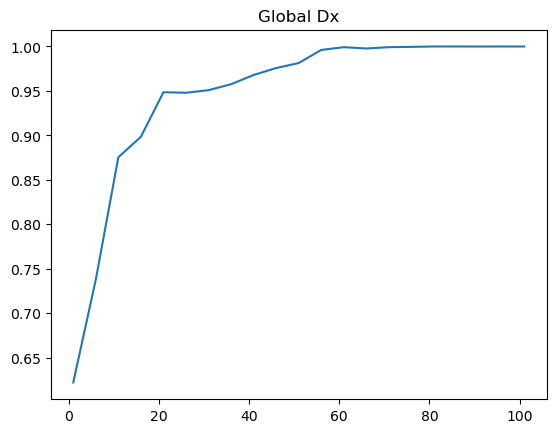

In [4]:
conf = 0.95

rf_res = pd.concat(
    [pd.read_csv(df) for df in glob.glob(f"{output_path}auc_df_rf_{name}_*.csv")]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

results_path = "data/classification/new/global/dx/results/"

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(f"{results_path}results_{name}.csv", index=False)

groups = ["qsampled", "m2"]
output_path = "data/classification/new/global/dx/"
name = f"rf_{groups[1]}_dx_random_order"
results_path = "data/classification/new/global/dx/results/"

df = pd.read_csv(f"{results_path}results_{name}.csv")

plt.plot(df["questions asked"], df["mean"])
plt.title("Global Dx")

# Bond court

## Core sampling

In [ ]:
_save_sampling_scenarios(
    iter=range(10),
    df=pd.read_csv("data/bondcourt/CCHHS_SUD_details.csv").drop(
        "Interview_ID", axis="columns"
    ),
    name="disson_new/bondcourt/core/disson_bond_qmra",
    diss_file=None,
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
    missing_value=np.nan,
    m2_method="unconditional",
)

## Classification

In [20]:
list(range(1, 43, 4))

[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41]

In [ ]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_new/bondcourt/core/disson_bond_qmra/random_order_disson*.pkl"
    )
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_new/bondcourt/core/disson_bond_qmra/random_order_disson*.pkl"
    )
]

groups = ["qsampled", "m2"]
output_path = "data/classification/new/bondcourt/core/"
name = f"rf_{groups[1]}_core_random_order"

auc_dfs = list()
plot = False
retrains = 3
n_trials = 50
question_iter = range(1, 43, 4)

classifier = RandomForestClassifier(n_jobs=-1)
# classifier = lgb.LGBMClassifier()


# for each dissonance file
for d in tqdm(diss, desc="Dissonance files"):
    # repeat performance calc
    for _ in tqdm(range(retrains), desc="Training cycles this file"):
        fig, ax = plt.subplots()
        aucs = list()
        z_aucs = list()
        z_aucs_lb = list()
        z_aucs_ub = list()
        roc_dfs = list()

        # which computes the auc for classifier at each question marker
        for questions_asked in question_iter:
            data = _diss_dataset(d, questions_asked, groups=groups)
            X_train, X_test, y_train, y_test = train_test_split(
                data.drop("y", axis="columns"), data["y"], test_size=0.33
            )

            # X_train = X_train.mean(axis=1)
            # X_test = X_test.mean(axis=1)

            def objective(trial):
                # pruning_callback = optuna.integration.LightGBMPruningCallback(
                #    trial, "auc"
                # )

                param = {
                    "n_estimators": trial.suggest_int("n_estimators", 50, 250),
                    "max_depth": trial.suggest_int("max_depth", 5, 15),
                    "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
                }

                classifier.set_params(**param)
                classifier.fit(
                    X_train.to_numpy(),
                    y_train.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    # callbacks=[pruning_callback],
                )

                r = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test.to_numpy(),
                    y_test.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    pos_label=1,
                    ax=ax,
                    name=questions_asked,
                )

                return r.roc_auc

            study = optuna.create_study(
                # pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                direction="maximize",
            )
            func = lambda trial: objective(trial, param)
            study.optimize(objective, n_trials=n_trials)

            classifier.set_params(**study.best_trial.params)
            classifier.fit(
                X_train.to_numpy(),
                y_train.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
            )

            r = RocCurveDisplay.from_estimator(
                classifier,
                X_test.to_numpy(),
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                pos_label=1,
                ax=ax,
                name=questions_asked,
            )
            aucs.append(r.roc_auc)
            fpr, tpr, thresholds = roc_curve(
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                classifier.predict_proba(X_test.to_numpy())[:, 1],
                pos_label=1,
            )
            roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
            roc_dfs.append(roc_df.assign(questions=questions_asked))
            if plot is False:
                plt.close()

            try:
                zt = zedstat.processRoc(
                    roc_df,
                    order=3,
                    total_samples=1000,
                    positive_samples=150,
                    alpha=0.01,
                    prevalence=0.15,
                )

                zt.smooth(STEP=0.01)
                zt.allmeasures(interpolate=False)
                zt.usample(precision=3)
                zt.getBounds()
                z_aucs.append(zt.auc()[0])
                z_aucs_lb.append(zt.auc()[2])
                z_aucs_ub.append(zt.auc()[1])
            except:
                z_aucs.append(r.roc_auc)
                z_aucs_lb.append(r.roc_auc)
                z_aucs_ub.append(r.roc_auc)

        auc_df = pd.DataFrame(
            {
                "questions asked": question_iter,
                "auc": aucs,
                "z_auc": z_aucs,
                "z_auc_lb": z_aucs_lb,
                "z_auc_ub": z_aucs_ub,
            }
        )

        if plot is True:
            ax = auc_df.plot(x="questions asked", y="z_auc")
            ax.fill_between(
                auc_df["questions asked"],
                auc_df["z_auc_ub"],
                auc_df["z_auc_lb"],
                alpha=0.25,
            )

        time = str(datetime.now())

        pd.concat(roc_dfs).to_csv(
            f"{output_path}roc_df_rf_{name}_{time}.csv",
            index=False,
        )
        auc_dfs.append(auc_df)
        auc_df.to_csv(
            f"{output_path}auc_df_rf_{name}_{time}.csv",
            index=False,
        )
    pd.concat(auc_dfs).groupby(level=0).mean().to_csv(
        f"{output_path}auc_dfs_rf_{name}_{datetime.now()}.csv",
        index=False,
    )

Text(0.5, 1.0, 'Bond court - core')

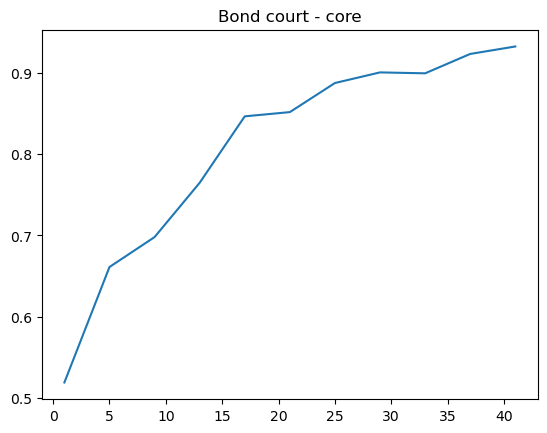

In [5]:
conf = 0.95

groups = ["qsampled", "m2"]
output_path = "data/classification/new/bondcourt/core/"
name = f"rf_{groups[1]}_core_random_order"
results_path = "data/classification/new/bondcourt/core/results/"

rf_res = pd.concat(
    [pd.read_csv(df) for df in glob.glob(f"{output_path}auc_df_rf_{name}_*.csv")]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

results_path = "data/classification/new/bondcourt/core/results/"

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(f"{results_path}results_{name}.csv", index=False)



df = pd.read_csv(f"{results_path}results_{name}.csv")

plt.plot(df["questions asked"], df["mean"])
plt.title("Bond court - core")